# Inertialization

This is a test implementation of the inertialization system from Epic Games.
https://cdn.gearsofwar.com/thecoalition/publications/GDC%202018%20-%20Inertialization%20-%20High%20Performance%20Animation%20Transitions%20in%20Gears%20of%20War.pdf

also thanks to portalmk2 for his implementation in Unity
https://github.com/portalmk2/InertializationForUnity


In [75]:
#import custom math classes
%run mtypes.py

#inline matplotlib
%matplotlib inline

#imports
import math
import matplotlib
import matplotlib.pyplot as plt

### TRANSITIONS AS A POST-PROCESS

● Capture pose difference between Source and Target

● Ease out the difference over time

● Remember Source velocity (via finite differences)

● Match initial velocity

● Quintic polynomial [Flash and Hogan 1985]

● Limit overshoot by controlling initial acceleration

● Choose a0 to give us zero jerk at t1

In [113]:
def inertialize(x0, v0, t1, t):
    
    #check if the velocity is going toward reaching 0 or not
    if v0 >= 0:
        v0 = 0
    else:
        t1adjusted = -5.0*x0/v0
        if t1adjusted > 0:
            t1 = min(t1, t1adjusted)
    t = min(t,t1)
            
    #compute the acceleration
    a0 = max((-8.0*v0*t1 - 20.0*x0)/(t1*t1),0)

    #compute the factors of the polynomial
    A = -(a0*t1*t1 + 6.0*v0*t1 + 12.0*x0)/(2.0*t1*t1*t1*t1*t1)
    B = (3.0*a0*t1*t1 + 16.0*v0*t1 + 30.0*x0)/(2.0*t1*t1*t1*t1)
    C = -(3.0*a0*t1*t1 + 12.0*v0*t1 +20.0*x0)/(2.0*t1*t1*t1)
    
    xt = A*t*t*t*t*t + B*t*t*t*t + C*t*t*t + a0*0.5*t*t + v0*t + x0 
    #print("x0:{}, v0:{}, t1:{}, t:{}, xt:{}".format(x0,v0,t1,t,xt))
    return xt

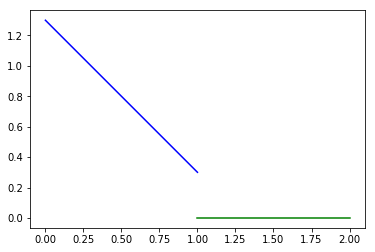

In [77]:
def draw_line(ax, x0, v, t0, t1, color):
    times = [t0 + (t1-t0)/20.0*i for i in range(21)]
    values = [x0 + v*t for t in times]
    ax.plot(times, values, color=color)


fig, ax = plt.subplots()
draw_line(ax, 1.3, -1, 0, 1, 'b')
draw_line(ax, 0, 0, 1, 2, 'g')
ax.set_aspect(1.0)
plt.show()


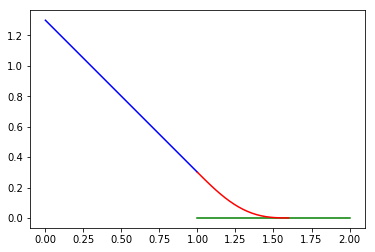

In [78]:
def draw_intertialize_value_curve(ax, x0, v0, t0, blendTime, color):
    times = [t0 + blendTime/20.0*i for i in range(21)]
    values = [inertialize(x0, v0, blendTime, blendTime/20.0*i) for i in range(21)]
    ax.plot(times, values, color=color)

fig, ax = plt.subplots()
draw_line(ax, 1.3, -1, 0, 1, 'b')
draw_line(ax, 0, 0, 1, 2, 'g')
draw_intertialize_value_curve(ax, 1.3-1, -1, 1, .6, 'r')
ax.set_aspect(1.0)
plt.show()

## Skeleton animation.

Inertialize between two animations.<br>
Let's load two simple anilmations from maya and see if we can inertialize between the 2.

#### skeleton

In [79]:
class Skeleton(object):

    class Bone(object):
        def __init__(self, pq, parent ):
            self.pq = pq
            self.parent = parent

    def __init__(self):
        self.bones = []

    def add(self, pq, parent):
        self.bones.append(self.__class__.Bone(pq, parent))

    def globalPq(self, id):
        if self.bones[id].parent < 0:
            return self.bones[id].pq.copy()
        return self.globalPq(self.bones[id].parent) * self.bones[id].pq

    def setGlobalPq(self, id, pq):
        newPosQuat = pq
        if self.bones[id].parent >= 0 :
            newPosQuat = self.globalPq(self.bones[id].parent).inverse() * pq
        self.bones[id].pq = newPosQuat.copy()
        
boneList = [
    "Hips", -1,
    "LeftUpLeg", 0,
    "LeftLeg", 1,
    "LeftFoot", 2,
    "LeftToeBase", 3,
    "RightUpLeg", 0,
    "RightLeg", 5,
    "RightFoot", 6,
    "RightToeBase", 7,
    "Spine", 0,
    "Spine1", 9,
    "LeftShoulder", 10,
    "LeftArm", 11,
    "LeftForeArm", 12,
    "LeftHand", 13,
    "RightShoulder", 10,
    "RightArm", 15,
    "RightForeArm", 16,
    "RightHand", 17,
    "Neck", 10,
    "Head", 19
]

def create_skeleton():
    skel = Skeleton()
    for i in range(1,len(boneList),2):
        skel.add(PosQuat(), boneList[i])
    return skel

def read_key(skel, anim, key):
    for i in range(len(skel.bones)):
        m = anim[i][1][key]
        m = Matrix([m[0:4],m[4:8],m[8:12],m[12:16]])
        skel.bones[i].pq = PosQuat.fromMatrix(m)
        
def draw_skeleton_points(ax, skel, color):
    for i in range(len(skel.bones)):
        pt = skel.globalPq(i).p._values
        ax.scatter(pt[0], pt[1], color=color)
        
def draw_skeleton_joints(ax, skel, color):
    for i in range(len(skel.bones)):
        if skel.bones[i].parent >= 0:
            
            pt = skel.globalPq(i).p._values
            ptparent = skel.globalPq(skel.bones[i].parent).p._values
            ax.plot([pt[0],ptparent[0]], [pt[1],ptparent[1]], color=color)
            
def draw_curve(ax, skel, anim, bone, length, color):
    xs = []
    ys = []
    for i in range(length):
        read_key(skel, anim, i)
        pt = skel.globalPq(bone).p._values
        xs.append(pt[0])
        ys.append(pt[1])
    ax.plot(xs,ys, color=color) 
    

#### load animations

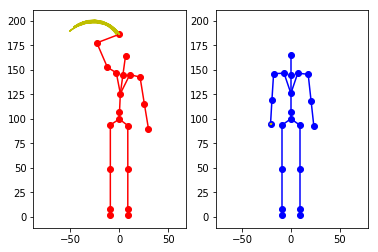

In [80]:
import pickle

with open('idle.dat', 'rb') as f:
    idleAnim = pickle.loads(f.read())
    
with open('wave.dat', 'rb') as f:
    waveAnim = pickle.loads(f.read())
    
idleSkel = create_skeleton()
read_key(idleSkel, idleAnim, 0)

waveSkel = create_skeleton()
read_key(waveSkel, waveAnim, 0)

ax = plt.subplot(1,2,1)
draw_skeleton_points(plt, waveSkel, 'r')
draw_skeleton_joints(plt, waveSkel, 'r')
draw_curve(plt, waveSkel, waveAnim, 18, 60, 'y')
ax.set_aspect(1.0)

ax = plt.subplot(1,2,2, sharey = ax)
draw_skeleton_points(plt, idleSkel, 'b')
draw_skeleton_joints(plt, idleSkel, 'b')
draw_curve(plt, idleSkel, idleAnim, 18, 60, 'y')
ax.set_aspect(1.0)

plt.show()


### Animation blend using lerp.

Let's blend the two animations and see the trajectory created.

We will display different timing and starting points.

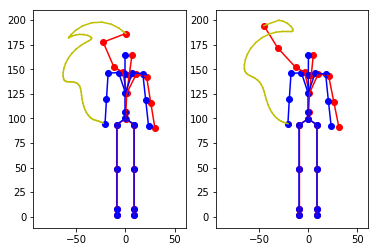

In [130]:
def blend_animation(skelA, skelB, skelOut, ratio):
    for a, b, out in zip(skelA.bones, skelB.bones, skelOut.bones):
        out.pq = PosQuat.lerp(a.pq, b.pq, ratio)
        
idleSkel = create_skeleton()
read_key(idleSkel, idleAnim, 0)

waveSkel = create_skeleton()
read_key(waveSkel, waveAnim, 0)

blendSkel = create_skeleton()
read_key(blendSkel, waveAnim, 0)


ax = plt.subplot(1,2,1)

draw_skeleton_points(plt, waveSkel, 'r')
draw_skeleton_joints(plt, waveSkel, 'r')

draw_skeleton_points(plt, idleSkel, 'b')
draw_skeleton_joints(plt, idleSkel, 'b')

for i in range(60):
    read_key(idleSkel, idleAnim, i)
    read_key(waveSkel, waveAnim, i)
    
    start = blendSkel.globalPq(18).p._values
    blend_animation(waveSkel, idleSkel, blendSkel, i/60.0)
    end = blendSkel.globalPq(18).p._values
    plt.plot([start[0],end[0]], [start[1],end[1]], color='y')

ax.set_aspect(1.0)

read_key(idleSkel, idleAnim, 10)
read_key(waveSkel, waveAnim, 10)
read_key(blendSkel, waveAnim, 10)

ax = plt.subplot(1,2,2, sharey=ax)

draw_skeleton_points(plt, waveSkel, 'r')
draw_skeleton_joints(plt, waveSkel, 'r')

draw_skeleton_points(plt, idleSkel, 'b')
draw_skeleton_joints(plt, idleSkel, 'b')

for i in range(13, 54):
    read_key(idleSkel, idleAnim, i)
    read_key(waveSkel, waveAnim, i)
    
    start = blendSkel.globalPq(18).p._values
    blend_animation(waveSkel, idleSkel, blendSkel, (i-13.0)/40.0)
    end = blendSkel.globalPq(18).p._values
    plt.plot([start[0],end[0]], [start[1],end[1]], color='y')

ax.set_aspect(1.0)

## Inertialize Skeleton.

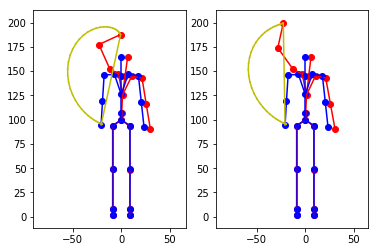

In [131]:
def inertialize_vector(previous, current, target, dt, blendTime, t):
    vx0 = current - target
    vxm1 = previous - target
    
    x0 = vx0.length()
    if x0 < 0.01:
        return target
    
    vx0_dir = vx0.normalize()

    xm1 = vxm1.dot(vx0_dir)
    v0 = (x0 - xm1) / dt
    
    xt = inertialize(x0, v0, blendTime, t)
    
    result = target + vx0_dir.scale(xt)
    #print(previous,current, target, vx0, vxm1, x0, v0, xt, result)
    
    return result


def inertialize_quaternion(previous, current, target, dt, blendTime, t):
    q0 = current * target.conjugate()
    q1 = previous * target.conjugate()
     
    vx0, x0 = q0.normalize().axisAngle()
 
    xm1 = 2* math.atan(Vector(q1._values[1:4]).dot(vx0) / q1._values[0])
    
    v0 = (x0 - xm1) / dt
    
    xt = inertialize(x0, v0, blendTime, t)
    return (Quaternion.fromAxisAngle(vx0, xt) * target).normalize()
    
    
def draw_inertialize_skeleton(ax, previousSkel, currentSkel, targetAnim, blendFrame):
    
    workingSkel = create_skeleton()
    read_key(workingSkel, targetAnim, 0)
    
    t1 = float(blendFrame)/30.0
    for i in range(blendFrame):
        
        t = float(i)/30.0
        
        start = workingSkel.globalPq(18).p._values
        read_key(workingSkel, targetAnim, i)
        
        for prev, cur, out in zip(previousSkel.bones, currentSkel.bones, workingSkel.bones):
            p = inertialize_vector(prev.pq.p, cur.pq.p, out.pq.p, 1.0/30.0, t1, t)
            q = inertialize_quaternion(prev.pq.q, cur.pq.q, out.pq.q, 1.0/30.0, t1, t)
            out.pq = PosQuat(p=p, q=q)
            
        end = workingSkel.globalPq(18).p._values
        ax.plot([start[0],end[0]], [start[1],end[1]], color='y')
        #ax.scatter(end[0], end[1], color='y')

        
idleSkel = create_skeleton()
read_key(idleSkel, idleAnim, 0)
        
waveSkel0 = create_skeleton()
read_key(waveSkel0, waveAnim, 0)

waveSkel1 = create_skeleton()
read_key(waveSkel1, waveAnim, 1)


ax = plt.subplot(1,2,1)

draw_skeleton_points(plt, waveSkel1, 'r')
draw_skeleton_joints(plt, waveSkel1, 'r')

draw_skeleton_points(plt, idleSkel, 'b')
draw_skeleton_joints(plt, idleSkel, 'b')

draw_inertialize_skeleton(plt, waveSkel0, waveSkel1, idleAnim, 40 )

ax.set_aspect(1.0)

read_key(waveSkel0, waveAnim, 13)
read_key(waveSkel1, waveAnim, 14)

ax = plt.subplot(1,2,2, sharey=ax)

draw_skeleton_points(plt, waveSkel1, 'r')
draw_skeleton_joints(plt, waveSkel1, 'r')

draw_skeleton_points(plt, idleSkel, 'b')
draw_skeleton_joints(plt, idleSkel, 'b')

draw_inertialize_skeleton(plt, waveSkel0, waveSkel1, idleAnim, 40 )

ax.set_aspect(1.0)
